In [1]:
import os
import numpy as np
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')


from pyspark import SparkContext
from pyspark.sql import SQLContext

# Loading custom built functions
from loader1 import load_spark_df, load_pandas_df
from model1 import get_best_rank, cross_validation

# Importing pyspark functins
import pyspark
from pyspark.sql.functions import split, explode
from pyspark.sql import Row
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.mllib.evaluation import RegressionMetrics, RankingMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


from sklearn.neighbors import NearestNeighbors

## 1. Loading Data 

We implement a function to cache and load the dataframe from secondary memory to reduce data load time

In [2]:
# Setting Directory path
base_path = os.getcwd()
dir_name = 'ml-latest-small'
CACHE_DIR = base_path + '/cache/'
DATA_DIR =  base_path + '/data/'

# Loading the Data Frames
movies_spark_df = load_spark_df(dir_name=dir_name, 
                                file_name='movies', 
                                use_cache=True,
                                DATA_DIR=DATA_DIR,
                                CACHE_DIR=CACHE_DIR
                               )

ratings_spark_df = load_spark_df(dir_name=dir_name, 
                                 file_name='ratings', 
                                 use_cache=True,
                                 DATA_DIR=DATA_DIR,
                                 CACHE_DIR=CACHE_DIR)

Loading from /media/anirudh/Data/Code/Fall 2019/Personalization/project/personalization_1/cache/ml-latest-small_movies.msgpack
Loading from /media/anirudh/Data/Code/Fall 2019/Personalization/project/personalization_1/cache/ml-latest-small_ratings.msgpack


## 2. Brute Force methods

### 2.1 Model based method using Alternating Least Squares method

We build a Matrix Factorization model using ALS method, and iterate over diffrent rank ranges to find the optimal rank

#### 2.1.1 Finding best hyperparameter setting using cross validation

In [ ]:
# Creating a Parameter Grid for ALS
model = ALS(userCol="userId",
                  itemCol="movieId",
                  ratingCol="rating",
                  coldStartStrategy="drop",
                  nonnegative=True)

paramGrid = ParamGridBuilder() \
            .addGrid(model.maxIter, [3]) \
            .addGrid(model.regParam, [0.01,0.1]) \
            .addGrid(model.rank, [64, 128]) \
            .build()

# Finding best parameter combination from cross validation
cross_validation(ratings_spark_df, 
                 model=model, 
                 evaluator='Regression', 
                 param_grid=paramGrid, 
                 k_folds=3)

#### 2.1.2 For diffrent ranks, plotting RMSE and coverage on training and test set

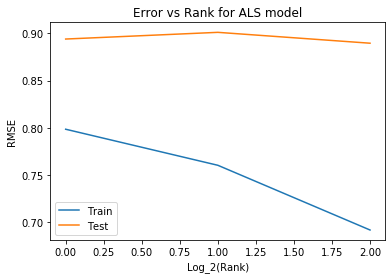

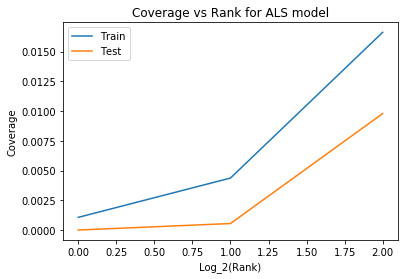

,Rank,RMSE_train,RMSE_test,Coverage_train,Coverage_test
0,1.0,0.798487,0.894001,0.001066,0.000000
1,2.0,0.760308,0.901097,0.004369,0.000544
2,4.0,0.691764,0.889585,0.016622,0.009793


In [3]:
# Plotting RMSE versus rank
pow_two_max_rank = 2
ranks = [2**i for i in range(pow_two_max_rank+1)]
report_dict = get_best_rank(ratings_spark_df, ranks=ranks)

plt.plot(list(report_dict[0].values()))
plt.plot(list(report_dict[1].values()))
plt.legend(['Train', 'Test'])
plt.xlabel("Log_2(Rank)")
plt.ylabel("RMSE")
plt.title("Error vs Rank for ALS model")
plt.show()

plt.plot(list(report_dict[2].values()))
plt.plot(list(report_dict[3].values()))
plt.legend(['Train', 'Test'])
plt.xlabel("Log_2(Rank)")
plt.ylabel("Coverage")
plt.title("Coverage vs Rank for ALS model")
plt.show()

display(report_dict[4])

### 2.2. Neighborhood based method using Nearest Neighbor

In [ ]:
def spark_to_sparse(spark_df, user_or_item='user'):
    df = spark_df.drop('timestamp')
    pd_df = df.toPandas()

    row = pd_df['userId'].values
    column = pd_df['movieId'].values
    values = pd_df['rating'].values

    num_rows = max(pd_df['userId'])
    num_columns = max(pd_df['movieId'])

    sparse_mat = np.empty([num_rows + 1, num_columns + 1])
    sparse_mat[row, column] = values
    if user_or_item == 'item':
        sparse_mat = sparse_mat.T
    elif user_or_item == 'user':
        pass
    else:
        sys.exit()

    sparse_mat = sparse.csr_matrix(sparse_mat)
    return sparse_mat


def get_nn(sparse_mat,
           num_neighbors=5,
           metric='euclidean',
           algorithm='auto',
           n_neighbors=5):

    model_knn = NearestNeighbors(
        metric='cosine', algorithm='brute', n_neighbors=5, n_jobs=-1)
    model_knn.fit(sparse_mat)
    distances, indices = model_knn.kneighbors(sparse_mat)
    raw_recommends = \
            sorted(
                list(
                    zip(
                        indices.squeeze().tolist(),
                        distances.squeeze().tolist()
                    )
                ),
                key=lambda x: x[1]
            )[:0:-1]
    
    return (raw_recommends, distances, indices)

In [ ]:
sparse_mat = spark_to_sparse(ratings_spark_df)
raw_re, distances, indices = get_nn(sparse_mat)

In [ ]:
split = [0.9,0.1]
rank = 2
train, test = ratings_spark_df.randomSplit(split, seed=1)
als = ALS(maxIter=5,
          regParam=0.09,
          rank=rank,
          userCol="userId",
          itemCol="movieId",
          ratingCol="rating",
          coldStartStrategy="drop",
          nonnegative=True)

model = als.fit(train)
evaluator = RegressionEvaluator(metricName="rmse",
                                labelCol="rating",
                                predictionCol="prediction")
predictions = model.transform(test)
rmse = evaluator.evaluate(predictions)
print(rmse)

In [ ]:
def calculate_coverage(model):
    user_recos = model.recommendForAllUsers(numItems=10)
    
    df1 = user_recos.select(explode(user_recos.recommendations).alias('col1'))
    df2 = df1.select('col1.*')
    df3 = df2.select('movieId').distinct()
    df4 = df3.toPandas()
    movie_set = df4['movieId'].values
    return movie_set

In [ ]:
pred_unique_movieids = calculate_coverage(model)
total_unique__movieids = ratings_spark_df.select('movieId').distinct().toPandas().values
coverage = 100*len(pred_unique_movieids)/len(total_unique__movieids)
print(f'Total Coverage: {coverage:.4f}')